## 深度解析bellman（groth16算法概览）

在导言中已经指出，prover最后计算出来的proof实际上是3个椭圆曲线上的点，读者一定很好奇，verifer怎么就能根据这三个点判断proof的正确性呢。这就要从groth16的算法中找寻原委了。groth16也是zksnark算法的一种，也是基于配对加密函数，因此它也有Setup、Prove、Verify等过程，基本原理包括LCP、Kate承诺等都是一脉相承的，只是其算法中进一步优化了proof size和crs大小。本文假定读者有一定的背景知识，聚焦在groth16算法本身，基础知识如R1CS、QAP、配对函数、FFT、iFFT等背景知识可以在零知识证明前传中找到，本文就不再赘述。

### 配对zkp算法范式
所有基于pairing算法的zkp，都有一个相同的计算范式，prover根据群的运算规则计算群元素，比如$a \in \mathbb F_q $，将其通过和群生成元$g$相乘，从而得到加密后的结果，而verifier运行配对函数，检查乘积的等式关系是否成立。

### 乘法门和QAP二次算术电路
$a \times b = c $构成了一个算术电路乘法门的要素，其中$a,b$是输入，$c$是输出，一个复杂的等式关系可以表示为:
$$ \sum a_i \cdot u_i \times \sum a_i \cdot v_i = \sum a_i \cdot w_i $$
其中 $u_i, v_i, w_i$ 是常量，而$a_i$ 是变量，其中部分变量用于表示statement，部分变量表示witness，更进一步，如果把$u_i, v_i, w_i$ 换成不同的多项式，就得到QAP的一个定义：<br>
$$ R = \left\{ \begin{array}{} ( \phi, w) \:
\begin{array}{|c} \phi = (a_1, a_2, ... a_l) \in \mathbb F^l \\
w = (a_{l+1}, a_{l+2}, ... a_m) \in \mathbb F^{m-l} \\
\sum a_i \cdot u_i(x) \times \sum a_i \cdot v_i(x) = \sum a_i \cdot w_i(x)  \mod t(x) \\
tx = \prod _i^n (x-i) \end{array} \end{array} \right\} 
$$
R用来表示满足n个乘法门约束的QAP关系，其中t(x)是一个描述有多少个乘法门的多项式，如果只有一个乘法门，$t(x)=(x-1)$，有两个则为$t(x)=(x-1)(x-2)$，以此类推。

### Groth16算法-setup
setup用来生成特定电路的随机数向量$\tau = (\alpha, \beta, \gamma, \delta, x )$, 但$\tau$并不直接保持在crs里，而是通过两个vector，$[\sigma_1]_1, [\sigma_2]_2 $分别保存，其中$\sigma_1, \sigma_2 $ 计算如下：
$$ \sigma_1 = \left ( \begin{array}{lcl} \alpha, \beta, \delta, {\{x^i\}}_{i=0}^{n-1} ,\\
{\left\{ \frac {\beta*u_i(x)+\alpha*v_i(x)+w_i(x)}{\gamma} \right\}}_{i=0}^{l} ,\\
{\left\{ \frac {\beta*u_i(x)+\alpha*v_i(x)+w_i(x)}{\gamma} \right\}}_{i=l+1}^{m} ,\\
{\left\{ \frac {x^i*t(x)}{\delta} \right\}}_{i=0}^{n-2}, \\
\end{array} \right ), 
\sigma_2 = \left ( \begin{array}{lcl} \beta, \gamma, \delta , \\
{\{x^i\}}_{i=0}^{n-1} \\
\end{array} \right )
$$
得到$\sigma_1, \sigma_2 $两个向量之后，也并不能直接保存在CRS里，而是保存其加密后的点vector$[\sigma_1]_1, [\sigma_2]_2 $，其中$[\sigma_1]_1 = \left \{\sigma_1[i] * g_1 \right \}，g_1$是G1的生成元，$[\sigma_2]_2 = \left \{\sigma_2[i] * g_2 \right \}，g_2$是G2的生成元。其中l表示有l个statement，m-l表示m-l个witeness。

#### tips：$\tau$需要特殊的方式生成
比如zcash是几个人坐热气球飞到天上来运行一个安全多方计算来生成，以太坊也有专门的讨论如何生成相关的$\tau$，一般来说如果一个严肃的zksnark项目，$\tau$的生成都会设计成一个盛典ceremony。这个5个随机数生成之后，就要忘掉它们，而只使用它们加密后的vector数据。$[\sigma_1]_1, [\sigma_2]_2 $

#### crs的参数大小
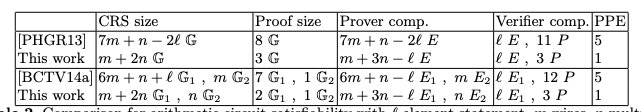
不解释，直接上表

#### bellman实现
位于generator.rs文件中，通过调用 generate_random_parameters 执行。知道了原理，代码就很好理解。
```
let g1 = E::G1::random(rng);
let g2 = E::G2::random(rng);
let alpha = E::Fr::random(rng);
let beta = E::Fr::random(rng);
let gamma = E::Fr::random(rng);
let delta = E::Fr::random(rng);
let tau = E::Fr::random(rng);
```
为免困惑，代码这里的$\tau$其实就是前文$\tau = (\alpha, \beta, \gamma, \delta, x )$中的$x$，注意分辨。

#####  alloc、alloc_input、enforce做了什么
```
/// This is our assembly structure that we'll use to synthesize the
/// circuit into a QAP.
struct KeypairAssembly<Scalar: PrimeField> {
    num_inputs: usize,
    num_aux: usize,
    num_constraints: usize,
    at_inputs: Vec<Vec<(Scalar, usize)>>,
    bt_inputs: Vec<Vec<(Scalar, usize)>>,
    ct_inputs: Vec<Vec<(Scalar, usize)>>,
    at_aux: Vec<Vec<(Scalar, usize)>>,
    bt_aux: Vec<Vec<(Scalar, usize)>>,
    ct_aux: Vec<Vec<(Scalar, usize)>>,
}
```

当alloc被调用分配一个变量x到a/b/c时，就保存一个Vec<(coefficient, constraint_number)>在at_aux/bt_aux/ct_aux中，对应到witness部分，在如果对照论文中属于$a_i, i=l+1, ..., m $，alloc_input分配一个变量x到a/b/c就保存一个Vec<(Scalar, usize)>在at_inputs/bt_inputs/ct_inputs中，对应到statements部分。(coefficient, constraint_number)这个就是LinearCombination，enforce用于将这些变量转换成正确的vector保存，需要指出的是，此处并没有执行比较 $a \times b = c $。 <br>

而KeypairAssembly正如代码注释所言，其将r1cs转换为QAP。所以这一步之后我们就把a，b，c转换成了$A_i(x), B_i(x), C_i(x)$，强调一点，$A_i(x), B_i(x), C_i(x)$ 是通过variable在不同门即$x=0,1,2...,l-1$处的值，绝大数情况下是0，少数情况下是1，由系数来决定，然后执行拉格朗日插值即可得到系数表达，完全由enforce生成的这些inputs/aux来决定，跟$x,\tau$的取值无关，可以视作常量。

### Groth16算法-prove
这一步就是用来创建proof的，proof在论文中通常记作$\pi = ([A]_1, [B]_2, [C]_1) $其中，$$ A = \alpha + {\sum_{i=0}^m a_i \cdot u_i(x) } + r*\delta \quad  B = \beta + {\sum_{i=0}^m a_i \cdot v_i(x) } + s*\delta \\
C = \frac {\sum_{i=l+1}^m a_i(\beta u_i(x)+\alpha v_i(x)+w_i(x))+h(x)t(x)}{\delta} + As + Br - rs\delta $$
其中r,s为prover随机选取的随机数。需要特别指出的是，其实是无法计算A、B、C的，因为$\tau$是加密存放的，所以这里是利用Setup保存的$[\sigma_1]_1, [\sigma_2]_2 $ 直接计算$\pi = ([A]_1, [B]_2, [C]_1) $

#### bellman实现
位于prover.rs文件中，通过调用 create_proof 执行。
##### 电路合成
```
    prover.alloc_input(|| "", || Ok(E::Fr::one()))?;

    circuit.synthesize(&mut prover)?;

    for i in 0..prover.input_assignment.len() {
        prover.enforce(|| "", |lc| lc + Variable(Index::Input(i)), |lc| lc, |lc| lc);
    }
```
###### 合成的细节 alloc、alloc_input、enforce做了什么
在create_proof里，同样会调用synthesize、alloc、alloc_input、enforce，不过是在struct ProvingAssignment里，并且与setup不同，alloc_input会把所有的input都放到input_assignment，并不像setup区分a，b，c，保存的vector元素也有区别；aux_assignment用于保存alloc申明的secret变量；enforce会顺序执行$a \times b = c $，并将结果分别放入a/b/c不同的vector中，这里就不得不惊叹rust语言trait的强大之处，跟go的interface完成的功能类似。

```
struct ProvingAssignment<E: Engine> {
    // Density of queries
    a_aux_density: DensityTracker,
    b_input_density: DensityTracker,
    b_aux_density: DensityTracker,

    // Evaluations of A, B, C polynomials
    a: Vec<Scalar<E>>,
    b: Vec<Scalar<E>>,
    c: Vec<Scalar<E>>,

    // Assignments of variables
    input_assignment: Vec<E::Fr>,
    aux_assignment: Vec<E::Fr>,
}
impl<S: PrimeField> ConstraintSystem<S> for ProvingAssignment<S> {
    type Root = Self;

    fn alloc<F, A, AR>(&mut self, _: A, f: F) -> Result<Variable, SynthesisError>
    where
        F: FnOnce() -> Result<S, SynthesisError>,
        A: FnOnce() -> AR,
        AR: Into<String>,
    {
        self.aux_assignment.push(f()?);
        self.a_aux_density.add_element();
        self.b_aux_density.add_element();

        Ok(Variable(Index::Aux(self.aux_assignment.len() - 1)))
    }

    fn alloc_input<F, A, AR>(&mut self, _: A, f: F) -> Result<Variable, SynthesisError>
    where
        F: FnOnce() -> Result<S, SynthesisError>,
        A: FnOnce() -> AR,
        AR: Into<String>,
    {
        self.input_assignment.push(f()?);
        self.b_input_density.add_element();

        Ok(Variable(Index::Input(self.input_assignment.len() - 1)))
    }

    fn enforce<A, AR, LA, LB, LC>(&mut self, _: A, a: LA, b: LB, c: LC)
    where
        A: FnOnce() -> AR,
        AR: Into<String>,
        LA: FnOnce(LinearCombination<S>) -> LinearCombination<S>,
        LB: FnOnce(LinearCombination<S>) -> LinearCombination<S>,
        LC: FnOnce(LinearCombination<S>) -> LinearCombination<S>,
    {
        let a = a(LinearCombination::zero());
        let b = b(LinearCombination::zero());
        let c = c(LinearCombination::zero());

        self.a.push(Scalar(eval(
            &a,
            // Inputs have full density in the A query
            // because there are constraints of the
            // form x * 0 = 0 for each input.
            None,
            Some(&mut self.a_aux_density),
            &self.input_assignment,
            &self.aux_assignment,
        )));
        self.b.push(Scalar(eval(
            &b,
            Some(&mut self.b_input_density),
            Some(&mut self.b_aux_density),
            &self.input_assignment,
            &self.aux_assignment,
        )));
        self.c.push(Scalar(eval(
            &c,
            // There is no C polynomial query,
            // though there is an (beta)A + (alpha)B + C
            // query for all aux variables.
            // However, that query has full density.
            None,
            None,
            &self.input_assignment,
            &self.aux_assignment,
        )));
    }
}
```
#### 计算C和h
上式中，计算A，B都相对简单，因为所有的元素都在setup中计算出来了，计算C比较复杂点，因为有一个多项式$h(x)$需要计算得到。
```
    let h = {
        let mut a = EvaluationDomain::from_coeffs(prover.a)?;
        let mut b = EvaluationDomain::from_coeffs(prover.b)?;
        let mut c = EvaluationDomain::from_coeffs(prover.c)?;
        a.ifft(&worker);
        a.coset_fft(&worker);
        b.ifft(&worker);
        b.coset_fft(&worker);
        c.ifft(&worker);
        c.coset_fft(&worker);

        a.mul_assign(&worker, &b);
        drop(b);
        a.sub_assign(&worker, &c);
        drop(c);
        a.divide_by_z_on_coset(&worker);
        a.icoset_fft(&worker);
        let mut a = a.into_coeffs();
        let a_len = a.len() - 1;
        a.truncate(a_len);
        // TODO: parallelize if it's even helpful
        let a = Arc::new(a.into_iter().map(|s| s.0.into()).collect::<Vec<_>>());

        multiexp(&worker, params.get_h(a.len())?, FullDensity, a)
    };
```
可以看出上面用到了4次ifft、3次fft

### Groth16算法-verify
verifer检查如下公式是否成立：
$$ [A]_1 \times [B]_2 = [\alpha]_1 \times [\beta]_2 + \sum_{i=0}^{l} a_i[\frac {\beta u_i(x)+\alpha v_i(x)+w_i(x)}{\gamma}]_1 \times [\gamma]_2 + [C]_1 \times [\delta]_2 $$

#### bellman实现
```
    if pvk.alpha_g1_beta_g2
        == E::multi_miller_loop(&[
            (&proof.a, &proof.b.into()),
            (&acc.to_affine(), &pvk.neg_gamma_g2),
            (&proof.c, &pvk.neg_delta_g2),
        ])
        .final_exponentiation()
    {
        Ok(())
    } else {
        Err(VerificationError::InvalidProof)
    }
```
里头就是配对函数最常用到的miller_loop，就不作过多的解释。

